<a href="https://colab.research.google.com/github/katetsu/Flexus-Debugging/blob/master/TokyoSingaporeJuelich_Cirq_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/quantumlib/Cirq/master/docs/_static/Cirq_logo_color.png"  height="80px"/>  [Thank you for the feedback!](https://forms.gle/oTG7xaT8zyq5svN88)

[Cirq](https://github.com/quantumlib/cirq) is a framework for writing quantum algorithms for noisy intermediate scale quantum (NISQ) devices. 

Roughly speaking, NISQ devices are those with O(100) qubits that can enact O(1000) gates.  Because the resources for NISQ devices are so constrained, we believe that a framework for writing programs on these devices needs to be aware of all of the architectural properties of the device on which the algorithm is written. This is in contrast to other frameworks where there is a clean separation between the abstract model being used and the details of the device.  

**This notebook provides an introduction to the Quantum Approximate Optimization Algorithm (QAOA) using the Cirq. The presentation mostly follows [Farhi et al.](https://arxiv.org/abs/1411.4028). We will show how to construct the QAOA circuit and use it to solve some simple problems.**

**Instructions**: Go to File --> Save Copy in Drive to get your own copy to play with.

**Note:** Be aware that Cirq is still alpha software, meaning **we are still making breaking changes all the time**. If you don't want your project to suddenly go from working to not working when we release a new version, you should depend on a *specific version* of Cirq and periodically bump that version to the latest one. For the purposes of this tutorial, we will use version of `0.6` (i.e. `cirq==0.6` in pip's version notation).

In [0]:
# install cirq
!pip install cirq==0.6 --quiet

To verify that Cirq is installed in your environment, try to `import cirq` and print out a diagram of the Bristlecone device.

In [0]:
import cirq
import numpy as np
import sympy
import matplotlib.pyplot as plt

print(repr(cirq.google.Bristlecone))

cirq.google.Bristlecone


>[Description of QAOA](#scrollTo=3wxPYfCo6Ygw)

>>[Toy problem: ground state of Ising model](#scrollTo=X15yPl_KQ20Z)

>>>[ZZ Gate](#scrollTo=VFwmWPf7D057)

>>>[Z Gate](#scrollTo=cy1ns-RLMzp3)

>>>[Exercise: More general two-qubit gate](#scrollTo=esgOuHF_FT_2)

>>[Exercise: Create Circuit](#scrollTo=uaDb6B_jPgrb)

>>>[Solution](#scrollTo=VEAt5QZvtPu_)

>>[Define Expectation Value](#scrollTo=3HtlMxa6QpVo)

>>>[Training - Brute Force](#scrollTo=r-CjbPwkRI_I)

>>>[Training - Gradient Descent](#scrollTo=9MwLJ0LCC0un)

>>>[Training - Results](#scrollTo=6UpLOKeso7uo)

>[Left to the reader as an exercise](#scrollTo=INtk-95kaUy5)

>>[Exercise: Repeat Using Sampling](#scrollTo=--aUfkiaUb3S)

>>[Exercise: Experiment with Different Numbers of Layers](#scrollTo=iIUkW0w4FGfa)

>>[Exercise: Try Ising Model on a different graph, or With Different Interaction Strengths](#scrollTo=9JRyH-WDVfMp)

>>[Exercise: Transverse field Ising Model](#scrollTo=klGsAVyNtxl2)



# Description of QAOA

Let's start out with a description of the QAOA algorithm. We'll discuss the structure of the problem it tries to solve and the quantum circuit we need to build to implement it.

Suppose you have a function $C(z)$ that depends on a collection of variables $z = z_1,z_2,\ldots, z_n$, where each $z_j$ can be equal to either $+1$ or $-1$ (the important thing here is that each $z_j$ has two possible values, and by convention we choose those values to be $\pm 1$). The QAOA is a general-purpose algorithm whose goal is to produce an assignment of the $z_j$ that gives a relatively low value of $C(z)$. It's not guaranteed to give the lowest possible value of $C(z)$---hence the name "Approximate"---except in a particular limit which we will discuss.

The QAOA algorithm acts on $n$ qubits. As you might guess, each qubit represents one of the variables in our function, and the $2^n$ states of the computational basis correspond to the $2^n$ possible assignments of the $z$ variables. To be more specific, let's agree that the value of $z_j$ corresponds to the measurement outcome of the Pauli-$Z$ operator on the $j$th qubit. There is a potential confusion here because the state $| 0 \rangle$ corresponds to $z = +1$, while the state $| 1\rangle$ corresponds to $z=-1$. This is unfortunate, but is something that we'll just have to deal with.

The QAOA algorithm is fairly simple to explain, though the reasons behind why it works are not obvious at first glance. As usual, we begin with all of our qubits initialized in the $|0\rangle$ state. The first step is to act with $H^{\otimes n}$, the Hadamard operator on each qubit. This prepares an equal superposition of all bitstrings, i.e., an equal superposition of all possible $z$ assignments:
$$
H^{\otimes n} |0^n\rangle =\frac{1}{2^{n/2}} \sum_{x \in \{0,1\}^n} |x\rangle.
$$
This should be thought of as the "real" initial state of the algorithm. **The point of the remaining steps is to affect the amplitudes so that those with small $C(z)$ values grow while those with large $C(z)$ values shrink. Then at the end when we measure the qubits we'll be more likely to find a bitstring with a small value of $C(z)$.**

The meat of the algorithm relies on the following unitary operator:
$$
U(\gamma,C) = e^{i\pi \gamma C(Z)/2}.
$$
This operator deserves some explanation. First, **$\gamma$ is a parameter which we will later treat as a variational parameter, adjusting its value to produce the best possible result**. $C$ here is the function we are trying to minimize, and the notation $C(Z)$ is supposed to tell you to plug in the Pauli-$Z$ operator for each qubit in place of the argument $z$. For example, if 
$$
C(z) = 3z_1 z_2 - z_2z_3 + z_4
$$
then
$$
C(Z) = 3Z_1 Z_2 - Z_2Z_3 + Z_4.
$$
It looks like I didn't do much, but the point here is that $C(z)$ is a number while $C(Z)$ is a matrix. That matrix is diagonal in the computational basis, and those diagonal entries represent all the possible values of $C(z)$.

After acting with $H^{\otimes n}$, we act with $U(C,\gamma)$. The result is still a sum over all possible bit-strings, but now the coefficients are complex phases which depend on $C$. At this point there is still an equal probability to measure any particular string, though, because Born's rule only depends on the square of the amplitude. So the algorithm is not done yet. Below we will have to figure out how to implement $U(\gamma, C)$ in Cirq so that we can perform this step in the algorithm.

The next step of the algorithm is to act with the unitary operator
$$
U(\beta,B) = e^{i\pi\beta B/2},~~~ B = \sum_{j=1}^n X_j,
$$
where $\beta$ is another variational parameter. Since the Pauli-$X$ operators on each qubit commute with each other, we can alternatively write this as
$$
U(\beta, B) = \prod_{j=1}^n e^{i\pi\beta X_j/2}.
$$
**Note**: In Cirq, the XPowGate**beta actually implements $e^{(-i \pi \beta X / 2)}$. Be careful at the minus sign in the exponent.

So this is just a rotation of each qubit around the $X$-axis on the Bloch sphere by an amount determined by $\beta$. This operation is _not_ diagonal in the computational basis, and the resulting state will not be an equal superposition over all bitstrings. **So after this step there will be constructive and destructive interference, which hopefully leads to enhancement of states corresponding to small values of $C$.** This $U(\beta, B)$ is sometimes called a "mixing" operation. Note that, up to an inconsequential global phase, we can also write
$$
U(\beta, B) = \prod_{j=1}^n X_j^{\beta}.
$$

**The total circuit consists of repeating the previous two steps a total of $p\geq 1$ times, where the choice of $p$ is up to you.** The parameters $\gamma$ and $\beta$ can be chosen independently at each step. So at the conclusion of the circuit, the state of the qubits is
$$
|\gamma,\beta\rangle = U(\beta_p,B)U(\gamma_p,C)\cdots U(\beta_1,B)U(\gamma_1,C)H^{\otimes n}|0^n\rangle.
$$
If we choose $\gamma$ and $\beta$ so that the expectation value
$$
F(\gamma,\beta) = \langle \gamma,\beta|C(Z)|\gamma,\beta\rangle
$$
is minimized, then measuring the state $|\gamma,\beta\rangle$ in the computational basis gives us a good candidate bitstring for the minimum of $C(z)$. That's the whole thing!

In summary we have to perform the following tasks in order to implement the QAOA:


1.   Figure out out to perform the $U(\gamma, C)$ operation in Cirq for our choice of $C$.
2.   Create a quantum circuit alternating $U(\gamma, C)$ and $U(\beta, B)$ operations as many times as desired. 
3.   Find the optimal value of the variational parameters in our circuit.
4.   Measure the output of our circuit.

## Toy problem: ground state of Ising model

The Ising Model defines the energy function
$$
E = -\sum_{\langle i,j \rangle} Z_i Z_j - \sum_i h_i Z_i,
$$
where the notation $\langle i,j\rangle$ means a sum over all nearest-neighbor pairs. The picture here is that the qubits live on the vertices of a graph, and the edges of the graph define which qubits are neighbors. We'll just take out graph to be a rectangular lattice with some number of rows and some number of columns. The numbers $h_i$ have the physical interpretation of an external magnetic field.

We are interested in finding a low-lying state of the Ising Model, by which I mean a state that has a relatively low amount of energy. This is a difficult problem in general. The pairwise interaction terms would tell you that neighboring qubits should be in the same state to lower the energy, while the magnetic field terms tell you that a given qubit wants to point "in the same direction" as its local field, and the strength of that preference depends on the magnitude of the field. These two different kinds of pressure are not always in agreement!

This type of problem is a perfect candidate for the QAOA, where we use the energy $E$ as our cost function $C$.

### ZZ Gate

The first thing we need to do is create the operation $U(\gamma, C)$, where $C$ is equal to the Ising Model energy function. The first thing to note is that, since all of the terms in the energy commute, we can decompose this operation as
$$
U(\gamma, C) = \prod_{\langle i,j\rangle}e^{-i\pi\gamma Z_iZ_j/2} \prod_i e^{-i\pi \gamma h_i Z_i/2}.
$$
This requires that we have the two-qubit gate $\exp(-i\pi\gamma ZZ/2)$ at our disposal. In matrix form, this is
$$
\begin{align}
\exp(-i \pi\gamma Z\otimes Z/2) = \begin{bmatrix}
e^{-i\pi \gamma/2}  & 0  &0&0\\
0 & e^{i\pi \gamma/2}   &0&0\\
0&0& e^{i\pi \gamma/2}  &0 \\
0&0 & 0  & e^{-i\pi \gamma/2}
\end{bmatrix}
\end{align}
$$
Cirq has a built-in gate `cirq.ZZ` which is equivalent to this once you account for a global phase:

In [0]:
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
gamma = 0.3 # Put your own value here.
circuit = cirq.Circuit(cirq.ZZ(a,b)**gamma)
print(circuit)
cirq.unitary(circuit).round(2)

a: ───ZZ───────
      │
b: ───ZZ^0.3───


array([[1.  +0.j  , 0.  +0.j  , 0.  +0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.59+0.81j, 0.  +0.j  , 0.  +0.j  ],
       [0.  +0.j  , 0.  +0.j  , 0.59+0.81j, 0.  +0.j  ],
       [0.  +0.j  , 0.  +0.j  , 0.  +0.j  , 1.  +0.j  ]])

We should also check that the matrix is what we expect:

In [0]:
test_matrix = np.array([[np.exp(-1j*np.pi*gamma/2),0, 0, 0],
                        [0, np.exp(1j*np.pi*gamma/2), 0, 0],
                        [0, 0, np.exp(1j*np.pi*gamma/2), 0],
                        [0, 0, 0,np.exp(-1j*np.pi*gamma/2)]])

"""
Have a look at the functions from cirq.testing
"""
cirq.testing.assert_allclose_up_to_global_phase(test_matrix, cirq.unitary(circuit), atol=1e-5)

### Z Gate

The magnetic field terms can be handled in a similar way. The single-qubit unitary
$$
\exp(-i\pi \gamma hZ/2) = \begin{bmatrix}
e^{-i\pi \gamma h/2} & 0 \\
0 & e^{i\pi \gamma h/2}
\end{bmatrix}
$$
is equivalent up to global phase to `cirq.Z**(h*gamma)`:

In [0]:
a = cirq.NamedQubit("a")
gamma = 0.3 # Put your own value here.
h = 1.3 # Put your own value here.
circuit = cirq.Circuit(cirq.Z(a)**(gamma*h))

print(circuit)
print()
print(cirq.unitary(circuit).round(2))

test_matrix = np.array([[np.exp(-1j*np.pi*gamma*h/2),0],
                        [0, np.exp(1j*np.pi*gamma*h/2)]])
cirq.testing.assert_allclose_up_to_global_phase(test_matrix, cirq.unitary(circuit), atol=1e-5)

a: ───Z^0.39───

[[1.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.34+0.94j]]


### Exercise: More general two-qubit gate

The Ising Model is particularly simple because the nearest-neighbor interaction $Z_i Z_j$ is already given in terms of a product of Pauli matrices. But suppose instead that the cost function was a sum of terms that looked like
$$
C(z_i,z_j) = \begin{cases}
c_{00} \text{ if } z_i =1,~z_j=1,\\
c_{01} \text{ if } z_i =1,~z_j=-1,\\
c_{10} \text{ if } z_i =-1,~z_j=1,\\
c_{11} \text{ if } z_i =-1,~z_j=-1.
\end{cases}
$$
For some numbers $c_{ab}$. How would you make the analogous two-qubit gate for this case?

You can either make a custom gate from scratch, or build a solution from the standard elementary gates.

## Exercise: Create Circuit

Using the `cirq.ZZ` gate we can now create the QAOA circuit. We're going to focus on the Ising Model an a rectangular lattice with an arbitrary number of rows and columns. Here are some things to think about:

1.   `cirq.GridQubit`s are natural because our qubits actually do live on a grid. Cirq does not care what kind of qubit you make, though.
2.   It's a good idea to define separate functions to place the C and B layers for the circuit. Really these should be generators that yield the required gates.
3.   You might consider wrapping everything inside a class. We won't do that here, but if you want to play around with different numbers of rows/columns or different numbers of B/C layers it can be convenient.

First we'll define the basic parameters of our model and the generators for the different layers:



In [0]:
n_cols = 3
n_rows = 3
h = 0.5*np.ones((n_rows,n_cols))

# Arranging the qubits in a list-of-lists like this makes them easy to refer to later.
# You can also have a look at the Cirq devices
# https://cirq.readthedocs.io/en/stable/generated/cirq.Device.html
qubits = [[cirq.GridQubit(i,j) for j in range(n_cols)] for i in range(n_rows)]

def beta_layer(beta):
  """Generator for U(beta, B) layer (mixing layer) of QAOA"""
  for row in qubits:
    for qubit in row:
      yield cirq.X(qubit)**beta
    
def gamma_layer(gamma, h):
  """Generator for U(gamma, C) layer of QAOA
  
  Args:
    gamma: Float variational parameter for the circuit
    h: Array of floats of external magnetic field values
  """
  for i in range(n_rows):
    for j in range(n_cols):
      if i < n_rows-1:
        yield cirq.ZZ(qubits[i][j], qubits[i+1][j])**gamma
        
      if j < n_cols-1:
        yield cirq.ZZ(qubits[i][j], qubits[i][j+1])**gamma
        
      yield cirq.Z(qubits[i][j])**(gamma*h[i,j])

Let's test these functions by constructing the circuit. Try making a circuit with different numbers of layers. How would you automatically make a circuit with a specified number of layers? Make sure the parameters of these layers are distinct `sympy.Symbol`s for later optimization. Print the circuit to see that it's doing what you want it to do.

In [0]:
qaoa = cirq.Circuit()
qaoa.append(cirq.H.on_each(*[q for row in qubits for q in row]))

"""
YOUR CODE HERE
"""

print(qaoa)

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(1, 0): ───H───

(1, 1): ───H───

(1, 2): ───H───

(2, 0): ───H───

(2, 1): ───H───

(2, 2): ───H───


### Solution

We'll just illustrate the solution for a single $C$ layer and a single $B$ layer.

In [0]:
qaoa = cirq.Circuit()

# The initialisation of the qubits with Hadamard gates
qaoa.append(cirq.H.on_each(*[q for row in qubits for q in row]))

# A gamma layer parameter
gamma = sympy.Symbol('g')

# A beta layer parameter
beta = sympy.Symbol('b')

# The layers
qaoa.append(gamma_layer(gamma,h))
qaoa.append(cirq.Moment(beta_layer(beta)))

# Print
print(qaoa)

                                                ┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ─────ZZ─────Z^(0.5*g)────────────────────────────────────────────────────────────────────────────────────────────X^b───
               │      │
(0, 1): ───H───┼──────ZZ^g───ZZ──────────ZZ──────Z^(0.5*g)────────────────────────────────────────────────────────────────────────X^b───
               │             │           │
(0, 2): ───H───┼─────────────┼───────────ZZ^g────ZZ────────────────────Z^(0.5*g)──────────────────────────────────────────────────X^b───
               │             │                   │
(1, 0): ───H───ZZ^g───ZZ─────┼───────────ZZ──────┼────────Z^(0.5*g)───────────────────────────────────────────────────────────────X^b───
                      │      │           │       │
(1, 1): ───H──────────┼──────ZZ^g────────ZZ^g────┼────────ZZ───────────ZZ───────────Z^(0.5*g)─────────────────────────────────────X^b───
                      │                   

## Define Expectation Value

To train the QAOA circuit---that is, find the optimal values of the parameters---we're going to need to be able to compute the expectation value of the Ising Model energy. We'll do this within Cirq by defining an energy function.

We'll divide the total energy by the number of qubits to keep the numbers under control, basically because we expect the energy to scale with the size of the system.

If we were using real hardware, the only way to compute the expectation value of the energy would be to estimate it by sampling. Using the simulator we can alternatively compute the wavefunction and then get calculate the expectation value from that. Not only does this save us from having to worry about statistical error, it also tends to be faster that simulating the sampling process.

In [0]:
def energy_from_wavefunction(wf, h):
  """Computes the energy-per-site of the Ising Model directly from the
  a given wavefunction. 
  
  Args:
    wf: Array of size 2**(n_rows*n_cols) specifying the wavefunction.
    h: Array of shape (n_rows, n_cols) giving the magnetic field values.
  
  Returns:
    energy: Float equal to the expectation value of the energy per site 
  """
  
  n_sites = n_rows*n_cols

  # Z is an array of shape (n_sites, 2**n_sites). Each row consists of the 
  # 2**n_sites non-zero entries in the operator that is the Pauli-Z matrix on
  # one of the qubits times the identites on the other qubits. The
  # (i*n_cols + j)th row corresponds to qubit (i,j).
  Z = np.array([(-1)**(np.arange(2**n_sites) >> i) for i in range(n_sites-1,-1,-1)])

  # Create the operator corresponding to the interaction energy summed over all
  # nearest-neighbor pairs of qubits
  ZZ_filter = np.zeros_like(wf, dtype=float)
  for i in range(n_rows):
    for j in range(n_cols):
      if i < n_rows-1:
        ZZ_filter += Z[i*n_cols + j]*Z[(i+1)*n_cols + j]
      if j < n_cols-1:
        ZZ_filter += Z[i*n_cols + j]*Z[i*n_cols + (j+1)]

  energy_operator = -ZZ_filter - h.reshape(n_sites).dot(Z)
        
        
  # Expectation value of the energy divided by the number of sites
  return np.sum(np.abs(wf)**2 * energy_operator) / n_sites

We'll also need a helper function that computes the expected value of the energy given some parameters of the QAOA.

In [0]:
def energy_from_params(gamma, beta, qaoa, h):
  sim = cirq.Simulator()
  params = cirq.ParamResolver({'g':gamma, 'b':beta})
  wf = sim.simulate(qaoa, param_resolver = params).final_state
  return energy_from_wavefunction(wf, h)  

### Training - Brute Force

Now we need to figure out the best values of $\gamma$ and $\beta$ by minimizing the expectation value of the energy. We'll start by doing a brute-force search of the parameter space for illustrative purposes:

In [0]:
# This will take a lot of time
# Patience...
grid_size = 50
gamma_max = 2
beta_max = 2

energies = np.zeros((grid_size,grid_size))
for i in range(grid_size):
  for j in range(grid_size):
    energies[i,j] = energy_from_params(i*gamma_max/grid_size, j*beta_max/grid_size, qaoa, h)

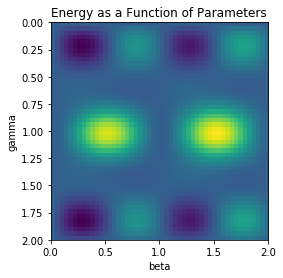

In [0]:
plt.ylabel('gamma')
plt.xlabel('beta')
plt.title('Energy as a Function of Parameters')
plt.imshow(energies, extent = (0,beta_max,gamma_max,0));

By inspection we can see that the energy function has a number of interesting properties. 

**There are many local minima and maxima**. This makes it challenging to use gradient-based methods for optimization. We'll see that explicitly next. Part of the challenge for algorithms of this type is finding efficient ways to optimize the parameters.

### Training - Gradient Descent

For practice let's try to minimize the expectation value of the energy using gradient descent. We know that there are local minima that we might get stuck in, depending on initialization, but it's still a worthwhile exercise.

**First step**: Define a function which approximates the gradient of the energy. We'll do this by symmetric difference, i.e., $f'(x) \approx (f(x+\epsilon)-f(x-\epsilon))/(2\epsilon)$. You should experiment with different values of $\epsilon$ as well as different formulas for the gradient. 

In [0]:
def gradient_energy(gamma, beta, qaoa, h):
  """Uses a symmetric difference to calulate the gradient."""
  eps = 10**-3 # Try different values of the discretization parameter
  
  # Gamma-component of the gradient
  grad_g = energy_from_params(gamma + eps, beta, qaoa, h)
  grad_g -= energy_from_params(gamma - eps, beta, qaoa, h)
  grad_g /= 2*eps
  
  # Beta-compoonent of the gradient
  grad_b = energy_from_params(gamma, beta + eps, qaoa, h)
  grad_b -= energy_from_params(gamma, beta - eps, qaoa, h)
  grad_b /= 2*eps  
  
  return grad_g, grad_b

**Second step**: Implement a gradient descent algorithm that minimizes the energy. Note that it will get stuck in local minima depending on the initialization.

In [0]:
gamma, beta = 0.2, 0.7 # Try different initializations
eta = 10**-2 # Try adjusting the learning rate.

# The number of gradient descent steps
nr_iterations = 151
for i in range(nr_iterations):
  # Compute the gradients
  grad_g, grad_b = gradient_energy(gamma, beta, qaoa, h)
  
  # Update gamma and beta using learning rate and gradients
  gamma -= eta*grad_g
  beta -= eta*grad_b
  
  if not i%25:
    # Every 25 steps print to console
    print('Step: {} Energy: {}'.format(i, energy_from_params(gamma, beta, qaoa, h)))
    
# The final parameters are
print('Learned gamma: {} Learned beta: {}'.format(gamma, beta, qaoa, h))

Step: 0 Energy: 0.3555180193569261
Step: 25 Energy: -0.6065681568234899
Step: 50 Energy: -0.6068778252132334
Step: 75 Energy: -0.6068778184267608
Step: 100 Energy: -0.6068776170906808
Step: 125 Energy: -0.6068782162255199
Step: 150 Energy: -0.6068778719321826
Learned gamma: 0.1975314540419846 Learned beta: 0.2684368583708869


### Training - Results

We've optimized our parameters. How well did we do?

For a $3\times 3$ grid we have $9$ qubits and $12$ interacting nearest-neighbor pairs. If all of the qubits are in the $|0\rangle$ state or all are in the $|1\rangle$ state, then the energy-per-qubit is $-12/9 = -1.33$ at zero external magnetic field $h$, and will be close to that if the magnetic field is small. Notice that the QAOA algorithm we analyzed above is __not__ getting close to that ground state. Is this a problem?

Well, not really. The QAOA algorithm still succeeds if we can  find the ground state after a small numbe of measurements. The QAOA prepares a certain state which is a linear combination of the ground state and many other states. When we measure the qubits, we find the ground-state configuration with some probability. If that probability is relatively large, then after a reasonably small number of measurements we'll locate the ground state.

**Practically speaking, this means we should measure the state prepared by the QAOA several times and record the lowest-energy state we find. The QAOA can be successful by biasing these measurements toward the ground state, even if they do not produce the ground state with $100\%$ probability.**

**First**: Let's make a copy of our qaoa circuit for measurement purposes and attach a measurement gate to each qubit:

In [0]:
measurement_circuit = qaoa.copy()
measurement_circuit.append(cirq.measure(*[qubit for row in qubits for qubit in row],key='m'))
measurement_circuit

┌──────────────────┐               ┌──────────────────┐
(0, 0): ───H───ZZ─────ZZ─────Z^(0.5*g)────────────────────────────────────────────────────────────────────────────────────────────X^b───M('m')───
               │      │                                                                                                                 │
(0, 1): ───H───┼──────ZZ^g───ZZ──────────ZZ──────Z^(0.5*g)────────────────────────────────────────────────────────────────────────X^b───M────────
               │             │           │                                                                                              │
(0, 2): ───H───┼─────────────┼───────────ZZ^g────ZZ────────────────────Z^(0.5*g)──────────────────────────────────────────────────X^b───M────────
               │             │                   │                                                                                      │
(1, 0): ───H───ZZ^g───ZZ─────┼───────────ZZ──────┼────────Z^(0.5*g)───────────────────────────────────────────────────────────────X^b───M────────
                      │      │           │       │                                                                                      │
(1, 1): ───H──────────┼──────ZZ^g────────ZZ^g────┼────────ZZ───────────ZZ───────────Z^(0.5*g)─────────────────────────────────────X^b───M────────
                      │                          │        │            │                                                                │
(1, 2): ───H──────────┼──────────────────────────ZZ^g─────┼────────────ZZ^g─────────ZZ────────────────────Z^(0.5*g)───────────────X^b───M────────
                      │                                   │                         │                                                   │
(2, 0): ───H──────────ZZ^g────────────────────────────────┼────────────ZZ───────────┼────────Z^(0.5*g)────────────────────────────X^b───M────────
                                                          │            │            │                                                   │
(2, 1): ───H──────────────────────────────────────────────ZZ^g─────────ZZ^g─────────┼─────────────────────ZZ──────────Z^(0.5*g)───X^b───M────────
                                                                                    │                     │                             │
(2, 2): ───H────────────────────────────────────────────────────────────────────────ZZ^g──────────────────ZZ^g────────Z^(0.5*g)───X^b───M────────
                                                └──────────────────┘               └──────────────────┘

**Second**:  Instantiate a simulator and measure the output of the circuit repeatedly:

In [0]:
num_reps = 10**3 # Try different numbers of repetitions
gamma, beta = 0.2,0.25 # Try different values of the parameters

simulator = cirq.Simulator()

# see https://cirq.readthedocs.io/en/stable/generated/cirq.ParamResolver.html
params = cirq.ParamResolver({'g':gamma, 'b':beta})

result = simulator.run(measurement_circuit, param_resolver = params, repetitions=num_reps)

**Finally**, we'll compute the energy for each of our measurement outcomes and look at the statistics.

We start with a helper function which calculates the energy given a set of measurement outcomes:

In [0]:
def compute_energy(meas, h):
  Z_vals = 1-2*meas.reshape(n_rows,n_cols)
  energy = 0
  for i in range(n_rows):
    for j in range(n_cols):
      if i < n_rows-1:
        energy -= Z_vals[i, j]*Z_vals[i+1, j]
      if j < n_cols-1:
        energy -= Z_vals[i, j]*Z_vals[i, j+1]
      energy -= h[i,j]*Z_vals[i,j]
  return energy/(n_rows*n_cols)

Now consider the 10 most common outputs of our measurements, and compute the energies of those:

In [0]:
hist = result.histogram(key='m')
num = 10
probs = [v/result.repetitions for _,v in hist.most_common(num)]
configs = [c for c,_ in hist.most_common(num)]

Fraction of outputs displayed: 0.25


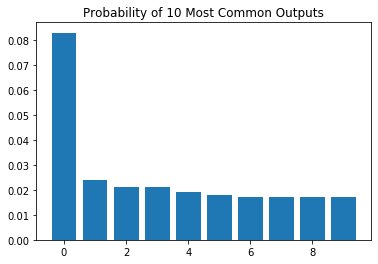

In [0]:
print('Fraction of outputs displayed: {}'.format(np.sum(probs).round(2)))

plt.title('Probability of {} Most Common Outputs'.format(num))
plt.bar([x for x in range(len(probs))],probs)
plt.show()

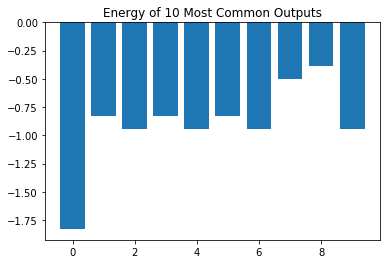

In [0]:
# a strange way to generate back binary expansion
meas = [[int(s) for s in ''.join([str(b) for b in bin(k)[2:]]).zfill(n_rows*n_cols)] for k in configs]

costs = [compute_energy(np.array(m), h) for m in meas]
plt.title('Energy of {} Most Common Outputs'.format(num))
plt.bar([x for x in range(len(costs))],costs)
plt.show()

We see that, for a good choice of $\gamma$ and $\beta$, ground state is the most probable outcome.

Try changing the values of $\gamma$ and $\beta$ away from the optimal ones. You'll see that this experiment no longer finds the ground state for us.

# Left to the reader as an exercise

## Exercise: Repeat Using Sampling

On real hardware we need to use sampling to estimate expectation values.

Adjust your code so that sampling is used instead of wavefunction evaluation.

How many samples do you need to take to get good results? Try different values.





## Exercise: Experiment with Different Numbers of Layers
See if you can get a closer to the true ground state (i.e., a larger fraction of measurements yielding the minimal energy) by adding more layers to the circuit.

## Exercise: Try Ising Model on a different graph, or With Different Interaction Strengths
Instead of a square lattice, you can try to formulate the Ising Model on any graph you like. This just changes which qubits you link in the $U(\gamma, C)$ layer. Each edge of the graph could also come with a different interaction coefficient, so that instead of $\exp(i\pi \gamma Z_iZ_j/2)$ for that edge you would have $\exp(i\pi \gamma J_{ij}Z_iZ_j/2)$ for some matrix $J_{ij}$ of coefficients. Note that you have to change both the $U(\gamma, C)$ layer and the definition of the energy function to make this work.

## Exercise: Transverse field Ising Model
The Ising Model with transverse field replaces the $\sum h_i Z_i$ term with a $\sum h_i X_i$ term. Can we use the QAOA here as well? What are the differences?
This is no longer a classical problem: in general the ground state will now be a superposition of elements of the computational basis. Can you make a circuit that prepares a state close to the gound state?

